In [1]:
from collections import namedtuple
from itertools import pairwise

import igraph as ig
from tqdm import tqdm

In [2]:
with open("input.txt", "rt") as f:
    trails = f.read().strip().split("\n")

In [3]:
Point = namedtuple("Point", ["x", "y"])


def up(p: Point) -> Point:
    return Point(p.x, p.y - 1)


def left(p: Point) -> Point:
    return Point(p.x - 1, p.y)


def right(p: Point) -> Point:
    return Point(p.x + 1, p.y)


def down(p: Point) -> Point:
    return Point(p.x, p.y + 1)


def trails_lookup(p: Point) -> Point:
    try:
        return trails[p.y][p.x]
    except IndexError:
        return "#"

start_point = Point(trails[0].index("."), 0)
target_point = Point(trails[-1].index("."), len(trails) - 1)

# Part 1

Bruteforce the longest path by simulating traversing all possible paths.


In [4]:
max_path_length = 0
branches_queue = [
    {
        "branch_start": start_point,
        "path_length": 0,
        "visited": {start_point},
    }
]
while branches_queue:
    branch = branches_queue.pop(0)
    position = branch["branch_start"]
    while True:
        branch["visited"].add(position)

        available_to_go = []
        for direction in (up, left, right, down):
            step = direction(position)
            # fmt: off
            if step not in branch["visited"] and (
                trails_lookup(step) == "."
                or trails_lookup(step) == "^" and direction.__name__ == "up"
                or trails_lookup(step) == "<" and direction.__name__ == "left"
                or trails_lookup(step) == ">" and direction.__name__ == "right"
                or trails_lookup(step) == "v" and direction.__name__ == "down"
            ):
            # fmt: on
                available_to_go.append(step)

        if len(available_to_go) == 0:
            if position == target_point:
                max_path_length = max(max_path_length, branch["path_length"])
            break

        elif len(available_to_go) == 1:
            position = available_to_go[0]
            branch["path_length"] += 1

        else:
            for step in available_to_go:
                branched_visited = branch["visited"].copy()
                branched_visited.add(step)
                branches_queue.append(
                    {
                        "branch_start": step,
                        "path_length": branch["path_length"] + 1,
                        "visited": branched_visited,
                    }
                )
            break


max_path_length

2246

# Part 2

`> pip install igraph`

Build a graph out of paths and bruteforce search for the longest path.

In [5]:
edges = []

Branch = namedtuple("Branch", ["edge_start", "position"])
branches = {Branch(start_point, down(start_point))}
visited = set()
while branches:
    branch = branches.pop()
    edge_length = 1

    position = branch.position
    while True:

        to_go = []
        for direction in (up, left, right, down):
            step = direction(position)
            if trails_lookup(step) in ".^<>v":
                to_go.append(step)

        if len(to_go) < 3:
            visited.add(position)

        available_to_go = [
            p for p in to_go if p not in visited and p != branch.edge_start
        ]

        if len(available_to_go) == 1 and len(to_go) == 2:
            position = available_to_go[0]
            edge_length += 1

        elif len(available_to_go) == 0 and len(to_go) == 2:
            break

        else:
            edges.append((branch.edge_start, position, edge_length))
            for step in available_to_go:
                branches.add(Branch(position, step))
            break

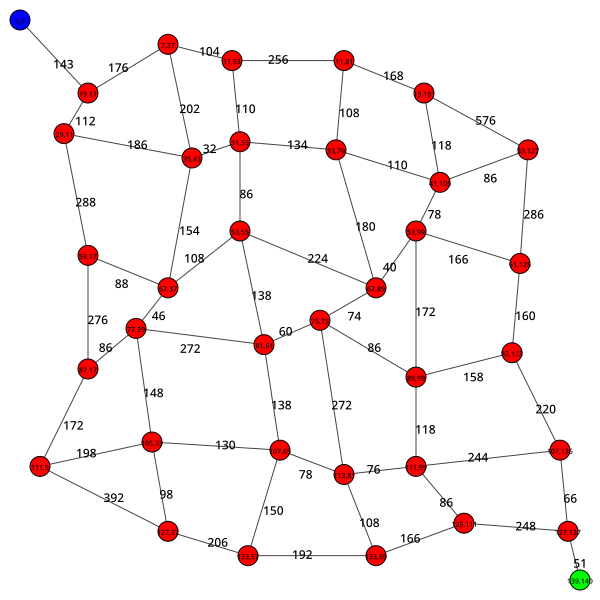

In [6]:
vs_ids = {}
ig_es = []
ig_es_attrs = []

last_node_id = -1
for p, q, length in edges:
    for vertex in (p, q):
        if vertex not in vs_ids:
            last_node_id += 1
            vs_ids[vertex] = last_node_id

    ig_es.append((vs_ids[p], vs_ids[q]))
    ig_es_attrs.append({"weight": length})


g = ig.Graph(n=last_node_id, edges=ig_es, directed=False)
g.vs[vs_ids[start_point]]["color"] = "blue"
g.vs[vs_ids[target_point]]["color"] = "green"
for edge_id, attrs in enumerate(ig_es_attrs):
    g.es[edge_id]["weight"] = attrs["weight"]
    g.es[edge_id]["label"] = attrs["weight"]
for point, vertex_id in vs_ids.items():
    g.vs[vertex_id]["label"] = f"{point.x},{point.y}"
    g.vs[vertex_id]["label_size"] = 7
layout = [(p.y, p.x) for p in vs_ids]
ig.plot(g, layout=layout)

In [7]:
max_length = 0
for path in tqdm(g.get_all_simple_paths(vs_ids[start_point], vs_ids[target_point])):
    length = 0
    for p, q in pairwise(path):
        length += g.es[g.get_eid(p, q)]["weight"]
    max_length = max(max_length, length)
max_length

100%|██████████| 1262816/1262816 [00:37<00:00, 33549.51it/s]


6622